In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import random

In [34]:
print(random.uniform(0,4))
print(random.randint(1,4))

2.7329201094270186
4


In [ ]:
class ZollmanEpistemicCommunity:
    def __init__(self, n_agents, network_type='complete', p_true=0.5):
        self.n_agents = n_agents
        self.network_type = network_type
        self.p_true = p_true  # True probability of the better theory
        self.p_false = 0.5 - (p_true - 0.5)  # False theory probability
        
        # Create communication network
        self.network = self._create_network()
        
        # Initialize agent beliefs
        # Each agent has a prior belief about each theory represented as beta distribution parameters
        self.beliefs = np.zeros((n_agents, 2, 2))  # [agent, theory, (alpha, beta)]
        for i in range(n_agents):
            # Initialize with uniform priors (Beta(1,1))
            self.beliefs[i, 0] = [1, 1]  # Prior for theory 0 (true)
            self.beliefs[i, 1] = [1, 1]  # Prior for theory 1 (false)
        
        # Track which theory each agent is currently using
        self.current_theory = np.random.randint(0, 2, n_agents)
        
        # History of beliefs and actions
        self.history = []
        self.record_state()
    
    def _create_network(self): #initialize social network
        if self.network_type == 'complete':
            # Complete graph: all agents connected to all others
            G = nx.complete_graph(self.n_agents)
        
        elif self.network_type == 'cycle':
            # Cycle: agents connected in a ring
            G = nx.cycle_graph(self.n_agents)
        
        elif self.network_type == 'wheel':
            # Wheel: one central agent connected to all others in a cycle
            G = nx.wheel_graph(self.n_agents)
        
        return G
    
    def record_state(self): #current state of community
        state = {
            'beliefs': self.beliefs.copy(),
            'current_theory': self.current_theory.copy()
        }
        self.history.append(state)
    
    def agent_chooses_theory(self, agent_id): #chose theory based on current beliefs
        # Calculate expected value for each theory
        ev0 = self.beliefs[agent_id, 0, 0] / (self.beliefs[agent_id, 0, 0] + self.beliefs[agent_id, 0, 1])
        ev1 = self.beliefs[agent_id, 1, 0] / (self.beliefs[agent_id, 1, 0] + self.beliefs[agent_id, 1, 1])
        
        # Choose theory with higher expected value
        if ev0 > ev1:
            self.current_theory[agent_id] = 0
        elif ev1 > ev0:
            self.current_theory[agent_id] = 1
        # If equal, keep current theory (no change)
    
    def perform_experiment(self, agent_id): #experiment with selected theory
        theory = self.current_theory[agent_id]
        
        # Determine outcome based on true probability of theory
        true_p = self.p_true if theory == 0 else self.p_false
        success = np.random.random() < true_p
        
        # Update agent's belief about the theory based on outcome
        if success:
            self.beliefs[agent_id, theory, 0] += 1  # Increment alpha (success)
        else:
            self.beliefs[agent_id, theory, 1] += 1  # Increment beta (failure)
        
        return success, theory
    
    def share_results(self, agent_id, experiment_result, theory): #social learning
        for neighbor in self.network.neighbors(agent_id):
            if experiment_result:  # Success
                self.beliefs[neighbor, theory, 0] += 1
            else:  # Failure
                self.beliefs[neighbor, theory, 1] += 1
    
    def simulate_round(self):
        for agent_id in range(self.n_agents):
            # Choose theory to investigate
            self.agent_chooses_theory(agent_id)
            
            # Perform experiment
            result, theory = self.perform_experiment(agent_id)
            
            # Share results with neighbors
            self.share_results(agent_id, result, theory)
        
        # Record the state after this round
        self.record_state()
    
    def run_simulation(self, n_rounds):
        for _ in range(n_rounds):
            self.simulate_round()
    
    def get_consensus(self): #check for convergence
        theories = self.current_theory
        if np.all(theories == 0):
            return "True theory"
        elif np.all(theories == 1):
            return "False theory"
        else:
            return "No consensus"
    
    def plot_network(self): #visualize network
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.network, seed=42)
        
        # Color nodes based on current theory choice
        colors = ['green' if t == 0 else 'red' for t in self.current_theory]
        
        nx.draw_networkx(self.network, pos, node_color=colors, 
                         node_size=500, with_labels=True)
        plt.title(f"Communication Network: {self.network_type}")
        plt.axis('off')
        plt.show()
    
    def plot_belief_evolution(self):
        means = []

        # Calculate mean belief in true theory for each round
        for state in self.history:
            beliefs = state['beliefs']
            means_round = []
            
            for agent in range(self.n_agents):
                alpha0, beta0 = beliefs[agent, 0]
                mean0 = alpha0 / (alpha0 + beta0)
                means_round.append(mean0)
            
            means.append(means_round)
        
        plt.figure(figsize=(10, 6))
        data = np.array(means)
        
        # Plot each agent's belief trajectory
        for agent in range(self.n_agents):
            plt.plot(data[:, agent], label=f"Agent {agent}")
        
        plt.axhline(y=self.p_true, color='green', linestyle='--', 
                   label=f"True probability ({self.p_true})")
        plt.axhline(y=0.5, color='gray', linestyle=':', 
                   label="Indifference threshold")
        
        plt.xlabel("Round")
        plt.ylabel("Belief in true theory")
        plt.title(f"Evolution of beliefs in {self.network_type} network")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [8]:
def compare_network_types(n_agents=10, n_rounds=50, n_simulations=100, p_true=0.6):
    network_types = ['complete', 'cycle', 'wheel']
    results = {nt: {'true': 0, 'false': 0, 'none': 0} for nt in network_types}
    
    for nt in network_types:
        print(f"Running {n_simulations} simulations for {nt} network...")
        
        for _ in range(n_simulations):
            comm = ZollmanEpistemicCommunity(n_agents=n_agents, 
                                           network_type=nt,
                                           p_true=p_true)
            comm.run_simulation(n_rounds)
            
            consensus = comm.get_consensus()
            if consensus == "True theory":
                results[nt]['true'] += 1
            elif consensus == "False theory":
                results[nt]['false'] += 1
            else:
                results[nt]['none'] += 1
    
    # Plot results
    plt.figure(figsize=(12, 6))
    x = np.arange(len(network_types))
    width = 0.25
    
    plt.bar(x - width, [results[nt]['true']/n_simulations*100 for nt in network_types], 
            width, label='True Theory', color='green')
    plt.bar(x, [results[nt]['false']/n_simulations*100 for nt in network_types], 
            width, label='False Theory', color='red')
    plt.bar(x + width, [results[nt]['none']/n_simulations*100 for nt in network_types], 
            width, label='No Consensus', color='gray')
    
    plt.xlabel('Network Type')
    plt.ylabel('Percentage of Simulations')
    plt.title(f'Consensus Results (p_true={p_true})')
    plt.xticks(x, network_types)
    plt.legend()
    plt.ylim(0, 100)
    
    for i, nt in enumerate(network_types):
        plt.text(i - width, results[nt]['true']/n_simulations*100 + 2, 
                f"{results[nt]['true']/n_simulations*100:.1f}%", 
                ha='center', va='bottom')
        plt.text(i, results[nt]['false']/n_simulations*100 + 2, 
                f"{results[nt]['false']/n_simulations*100:.1f}%", 
                ha='center', va='bottom')
        plt.text(i + width, results[nt]['none']/n_simulations*100 + 2, 
                f"{results[nt]['none']/n_simulations*100:.1f}%", 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

Running single simulation...


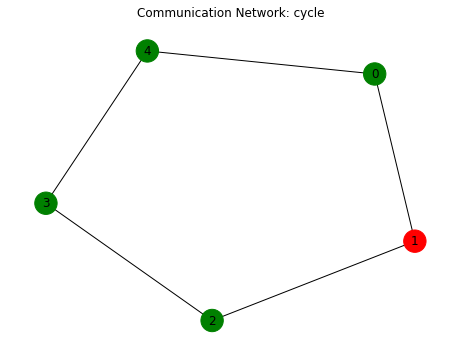

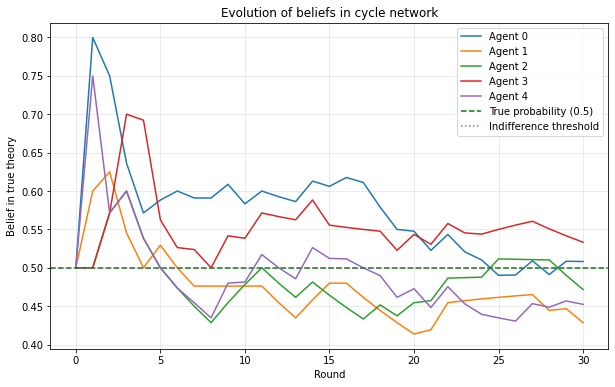

Final consensus: No consensus

Comparing different network types...
Running 50 simulations for complete network...
Running 50 simulations for cycle network...
Running 50 simulations for wheel network...


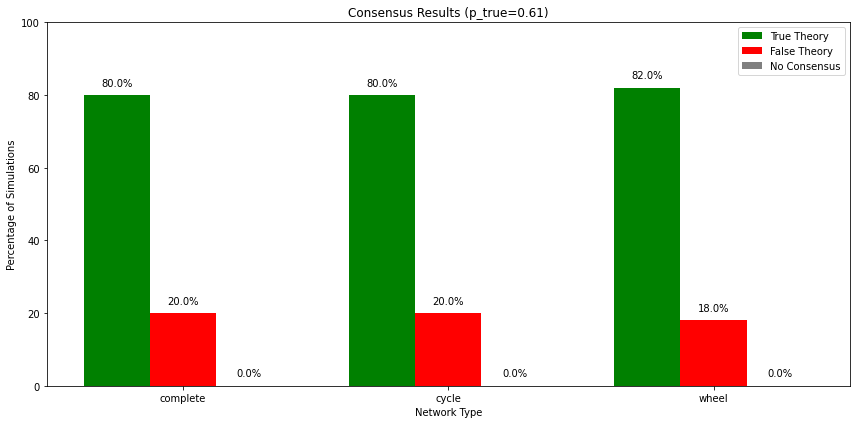

In [13]:
# Example usage
if __name__ == "__main__":
    # Single simulation example
    print("Running single simulation...")
    community = ZollmanEpistemicCommunity(n_agents=5, network_type='cycle', p_true=0.5)
    community.run_simulation(30)
    community.plot_network()
    community.plot_belief_evolution()
    print(f"Final consensus: {community.get_consensus()}")
    
    # Compare different network types
    print("\nComparing different network types...")
    compare_network_types(n_agents=3, n_rounds=50, n_simulations=50, p_true=0.61)